In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [475]:
# Calculate for each interval the profit and holding time for a given strategy
def get_statistics(df_stock, strategy='Suositus', price='Päätöskurssi + Osinko', day='PvmKaupankäynti'):
    salkussa = df_stock[strategy].shift(1).isin(['Lisää', 'Osta'])
    tuotto = df_stock[price]/df_stock[price].shift(1)
    pitoaika = (df_stock[day]-df_stock[day].shift(1)).dt.days
    tuotto_salkussa = np.where(salkussa, tuotto, 1.00).prod()
    pitoaika_salkussa = np.where(salkussa, pitoaika, 0).sum()
    statistics = { 
        'Tuotto': tuotto_salkussa,
        'Pitoaika': pitoaika_salkussa,
        'CAGR': tuotto_salkussa**(365/pitoaika_salkussa) if pitoaika_salkussa > 0 else 1.0
    }
    return(pd.Series(statistics))

In [476]:
# Calculate the geometric mean (CAGR) of a diversified stock portfolio from the arithmetic mean of holding the stocks, 
# given their total holding times when a recommendation was active (probability of exposure)
def geom_mean(cagr, exposure, n=1000):
    arit_avgs = []
    for b in range(n):
        holding = np.random.binomial(1, exposure)
        arit_avg = np.average(cagr, weights = holding) if holding.sum() > 0 else 1.0
        arit_avgs.append(arit_avg)
    geom_avg = np.exp(np.mean(np.log(arit_avgs)))
    return(geom_avg)

### Load data

In [477]:
recommendations = pd.read_csv("Suositukset_Uusi.csv", parse_dates=[1])
recommendations.rename(columns={'Pvm':'PvmSuositus'}, inplace=True)

In [478]:
recommendations.head()

,Osake,PvmSuositus,Suositus,Tavoite
0,Aallon Group,2019-04-09,Vähennä,8.5
1,Aallon Group,2019-08-22,Vähennä,9.0
2,Aallon Group,2019-09-28,Vähennä,9.0
3,Aallon Group,2019-12-11,Vähennä,9.9
4,Aallon Group,2020-02-14,Lisää,11.0


In [479]:
recommendations['Suositus'].value_counts(dropna=False)

Lisää      3217
Vähennä    3066
Osta        573
Myy         520
-            53
Name: Suositus, dtype: int64

### Price data

In [480]:
prices = pd.read_csv("Tuotto.csv", parse_dates=[1])
prices.rename(columns={'Päivämäärä':'PvmKaupankäynti'}, inplace=True)

In [481]:
prices.head()

,Osake,PvmKaupankäynti,Päätöskurssi,Osinko,Päätöskurssi + Osinko
0,Aallon Group,2019-04-09,8.600,0.0,8.600
1,Aallon Group,2019-04-10,8.465,0.0,8.465
2,Aallon Group,2019-04-11,8.500,0.0,8.500
3,Aallon Group,2019-04-12,8.500,0.0,8.500
4,Aallon Group,2019-04-15,8.500,0.0,8.500


### Combine

In [482]:
returns = recommendations.merge(prices, how='outer',  
                                left_on=['Osake', 'PvmSuositus'], 
                                right_on=['Osake', 'PvmKaupankäynti'], 
                                sort=True)#[['Osake', 'PvmSuositus', 'PvmKaupankäynti']]

In [483]:
# Fill the recommendation forward to all subsequent trading days
fill_cols = ['PvmSuositus', 'Suositus', 'Tavoite']
returns[fill_cols] = returns.groupby('Osake')[fill_cols].fillna(method='ffill')
returns.dropna(axis=0, subset=['PvmKaupankäynti'], inplace=True) #'PvmSuositus'

In [484]:
# For each recommendation day PvmSuositus add the next trading day PvmKaupankäynti (Seuraava) 
returns['PvmKaupankäynti (Seuraava)'] = returns.groupby('Osake')['PvmKaupankäynti'].apply(lambda s: s.shift(-1))
returns['Päätöskurssi (Seuraava)'] = returns.groupby('Osake')['Päätöskurssi'].apply(lambda s: s.shift(-1))
returns['Päätöskurssi + Osinko (Seuraava)'] = returns.groupby('Osake')['Päätöskurssi + Osinko'].apply(lambda s: s.shift(-1)) 

In [485]:
returns.head()

,Osake,PvmSuositus,Suositus,Tavoite,PvmKaupankäynti,Päätöskurssi,Osinko,Päätöskurssi + Osinko,PvmKaupankäynti (Seuraava),Päätöskurssi (Seuraava),Päätöskurssi + Osinko (Seuraava)
0,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-09,8.600,0.0,8.600,2019-04-10,8.465,8.465
1,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-10,8.465,0.0,8.465,2019-04-11,8.500,8.500
2,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-11,8.500,0.0,8.500,2019-04-12,8.500,8.500
3,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-12,8.500,0.0,8.500,2019-04-15,8.500,8.500
4,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-15,8.500,0.0,8.500,2019-04-16,8.450,8.450


# Recommendation intervals

In [486]:
intervals = returns.groupby(['Osake', 'PvmSuositus'], as_index=False).first()
intervals.head()

,Osake,PvmSuositus,Suositus,Tavoite,PvmKaupankäynti,Päätöskurssi,Osinko,Päätöskurssi + Osinko,PvmKaupankäynti (Seuraava),Päätöskurssi (Seuraava),Päätöskurssi + Osinko (Seuraava)
0,Aallon Group,2019-04-09,Vähennä,8.5,2019-04-09,8.60,0.0,8.60,2019-04-10,8.465,8.465
1,Aallon Group,2019-08-22,Vähennä,9.0,2019-08-22,9.50,0.0,9.50,2019-08-23,10.500,10.500
2,Aallon Group,2019-09-28,Vähennä,9.0,2019-09-30,9.24,0.0,9.24,2019-10-01,9.400,9.400
3,Aallon Group,2019-12-11,Vähennä,9.9,2019-12-11,10.45,0.0,10.45,2019-12-12,10.400,10.400
4,Aallon Group,2020-02-14,Lisää,11.0,2020-02-14,11.25,0.0,11.25,2020-02-17,12.000,12.000


### Additional information 

In [487]:
# Add 'Buy & Hold' recommendations
buyhold = {'-': '-', 'Osta': 'Lisää', 'Lisää': 'Lisää', 'Vähennä': 'Lisää', 'Myy': 'Lisää'}
intervals['Osta&Pidä'] = intervals['Suositus'].map(buyhold)
# Add 'Reverse' recommendations
reverse = {'-': '-', 'Osta': 'Myy', 'Lisää': 'Vähennä', 'Vähennä': 'Lisää', 'Myy': 'Osta'}
intervals['Käänteinen'] = intervals['Suositus'].map(reverse)

In [488]:
# Calculate for each interval (PvmEdellinen, Pvm) the profit and holding time
def add_statistics(df_stock):
    df_stock['PvmSuositusEdellinen'] = df_stock['PvmSuositus'].shift(1)
    df_stock['Salkussa'] = (df_stock['Suositus'].shift(1) == 'Lisää') | (df_stock['Suositus'].shift(1) == 'Osta')
    return(df_stock)
# Add info to each recommendation event
intervals = intervals.groupby('Osake').apply(add_statistics)

### Nokia example

In [489]:
osake = 'Nokia'
intervals_stock = intervals[intervals['Osake'] == osake]
intervals_stock[['Osake', 'PvmSuositus','Suositus', 'Tavoite', 'Osta&Pidä', 'Päätöskurssi', 'Päätöskurssi + Osinko', 'Salkussa']]

,Osake,PvmSuositus,Suositus,Tavoite,Osta&Pidä,Päätöskurssi,Päätöskurssi + Osinko,Salkussa
3735,Nokia,2013-01-07,Myy,2.4,Lisää,3.2800,4.858537,False
3736,Nokia,2013-01-10,Vähennä,3.0,Lisää,3.3240,4.923712,False
3737,Nokia,2013-01-11,Vähennä,3.0,Lisää,3.3960,5.030363,False
3738,Nokia,2013-01-24,Vähennä,3.0,Lisää,3.2960,4.882237,False
3739,Nokia,2013-03-14,Vähennä,2.5,Lisää,2.6800,3.969780,False
...,...,...,...,...,...,...,...,...
3799,Nokia,2021-03-19,Lisää,3.6,Lisää,3.4300,6.376449,True
3800,Nokia,2021-04-30,Lisää,4.5,Lisää,3.9425,7.329198,True
3801,Nokia,2021-07-14,Lisää,5.4,Lisää,5.0200,9.332296,True
3802,Nokia,2021-07-29,Lisää,5.8,Lisää,5.1750,9.620444,True


Text(0.5, 1.0, 'Nokia osakekurssi, tavoite ja suositus (lisää/vähennä)')

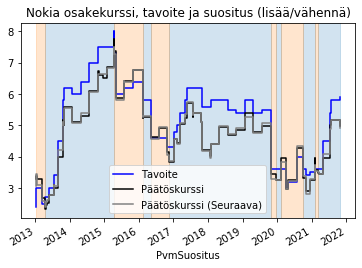

In [490]:
fig, ax = plt.subplots()
# Plot the stock and target price
target = intervals_stock.set_index('PvmSuositus')[['Tavoite', 'Päätöskurssi', 'Päätöskurssi (Seuraava)']]
target.plot(ax=ax, drawstyle='steps-post', color=['blue', 'black', 'grey'])
# Calculate the uniform intervals when stock is bought or sold
nth_interval = (intervals_stock['Salkussa'] != intervals_stock['Salkussa'].shift(1)).cumsum() 
intervals_reduced = intervals_stock.groupby(nth_interval).apply(lambda df_stock: pd.Series({
    'PvmSuositusEdellinen' : df_stock['PvmSuositusEdellinen'].min(), 
    'PvmSuositus'          : df_stock['PvmSuositus'].max(), 
    'Salkussa'     : df_stock['Salkussa'].max(),
}))
# Plot the intervals
from matplotlib.dates import date2num
for (x1, x2) in zip(date2num(intervals_reduced.loc[intervals_reduced['Salkussa'], 'PvmSuositusEdellinen']), 
                    date2num(intervals_reduced.loc[intervals_reduced['Salkussa'], 'PvmSuositus'])):
    ax.axvspan(xmin = x1, xmax = x2, color = 'tab:blue', alpha=0.2)
for (x1, x2) in zip(date2num(intervals_reduced.loc[~intervals_reduced['Salkussa'], 'PvmSuositusEdellinen']), 
                    date2num(intervals_reduced.loc[~intervals_reduced['Salkussa'], 'PvmSuositus'])):
    ax.axvspan(xmin = x1, xmax=x2, color = 'tab:orange', alpha=0.2)
ax.set_title('%s osakekurssi, tavoite ja suositus (lisää/vähennä)' % osake)

In [491]:
get_statistics(intervals_stock, strategy='Osta&Pidä', price='Päätöskurssi + Osinko', day='PvmKaupankäynti')

Tuotto         1.901672
Pitoaika    3217.000000
CAGR           1.075649
dtype: float64

In [492]:
get_statistics(intervals_stock, strategy='Suositus', price='Päätöskurssi + Osinko', day='PvmKaupankäynti')

Tuotto         6.116078
Pitoaika    2298.000000
CAGR           1.333271
dtype: float64

In [493]:
get_statistics(intervals_stock, strategy='Suositus', price='Päätöskurssi + Osinko (Seuraava)', day='PvmKaupankäynti (Seuraava)')

Tuotto         4.746014
Pitoaika    2300.000000
CAGR           1.280355
dtype: float64

### All stocks + estimated portfolio return

In [494]:
# Buy&Hold vs. Inderes (next trading day)
buyhold = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Osta&Pidä',
                               price='Päätöskurssi + Osinko (Seuraava)', day='PvmKaupankäynti (Seuraava)'))
inderes = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Suositus',
                               price='Päätöskurssi + Osinko (Seuraava)', day='PvmKaupankäynti (Seuraava)'))
statistics = buyhold.merge(inderes, on='Osake', suffixes=('_Osta&Pidä', '_Inderes'))

# Add reverse
reverse = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Käänteinen',
                               price='Päätöskurssi + Osinko (Seuraava)', day='PvmKaupankäynti (Seuraava)'))
reverse.rename(columns={'Tuotto': 'Tuotto_Käänteinen', 'CAGR': 'CAGR_Käänteinen', 'Pitoaika': 'Pitoaika_Käänteinen'}, inplace=True)
statistics = statistics.merge(reverse, on='Osake')

statistics

,Osake,Tuotto_Osta&Pidä,Pitoaika_Osta&Pidä,CAGR_Osta&Pidä,Tuotto_Inderes,Pitoaika_Inderes,CAGR_Inderes,Tuotto_Käänteinen,Pitoaika_Käänteinen,CAGR_Käänteinen
0,Aallon Group,1.419938,966.0,1.141654,1.050272,579.0,1.031403,1.351972,387.0,1.328993
1,Admicom,7.199924,1388.0,1.680545,2.126419,298.0,2.519503,3.385938,1090.0,1.504422
2,Afarak Group,0.476829,963.0,0.755252,1.000000,0.0,1.000000,0.476829,963.0,0.755252
3,Ahlstrom,0.605122,742.0,0.781062,1.000000,0.0,1.000000,0.605122,742.0,0.781062
4,Ahlstrom-Munksjö,1.046679,961.0,1.017479,1.072859,538.0,1.048869,0.975598,423.0,0.978908
...,...,...,...,...,...,...,...,...,...,...
164,Vincit,1.459014,1864.0,1.076776,1.103324,1338.0,1.027186,1.322381,526.0,1.213980
165,Wulff Group,3.858040,1161.0,1.528778,3.647781,739.0,1.894925,1.057640,422.0,1.049665
166,Wärtsilä B,1.493663,3233.0,1.046340,0.981421,961.0,0.992902,1.521939,2272.0,1.069799
167,YIT,0.517307,3213.0,0.927858,0.127066,1463.0,0.597677,4.071173,1750.0,1.340201


In [495]:
## Osta&Pidä vs. Inderes
#buyhold = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Osta&Pidä'))
#inderes = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Suositus'))
#statistics = buyhold.merge(inderes, on='Osake', suffixes=('_Osta&Pidä', '_Inderes'))
#statistics

In [496]:
(statistics['CAGR_Inderes'] > statistics['CAGR_Osta&Pidä']).value_counts()

True     103
False     66
dtype: int64

In [497]:
# Inderes yearly return
inderes_avg    = statistics.loc[statistics['Pitoaika_Inderes'] > 30, 'CAGR_Inderes'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Inderes'] / statistics['Pitoaika_Osta&Pidä'].max()).fillna(0)
inderes_mc = geom_mean(statistics['CAGR_Inderes'], exposure)

print(inderes_avg, inderes_mc)

1.2441993120756607 1.2619221140714576


In [498]:
# Inderes yearly return
reverse_avg    = statistics.loc[statistics['Pitoaika_Käänteinen'] > 30, 'CAGR_Käänteinen'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Käänteinen'] / statistics['Pitoaika_Osta&Pidä'].max()).fillna(0)
reverse_mc = geom_mean(statistics['CAGR_Käänteinen'], exposure)

print(reverse_avg, reverse_mc)

1.0402581423683568 1.035899258054826


In [499]:
# Inderes yearly return
indeksi_avg    = statistics.loc[statistics['Pitoaika_Osta&Pidä'] > 30, 'CAGR_Osta&Pidä'].mean()
# Inderes yearly return, taking into account exposure times with monte carlo estimate of the product integral
exposure = (statistics['Pitoaika_Osta&Pidä'] / statistics['Pitoaika_Osta&Pidä'].max()).fillna(0)
indeksi_mc = geom_mean(statistics['CAGR_Osta&Pidä'], exposure)

print(indeksi_avg, indeksi_mc)

1.1414782091832998 1.1317950620633457


### Visualization

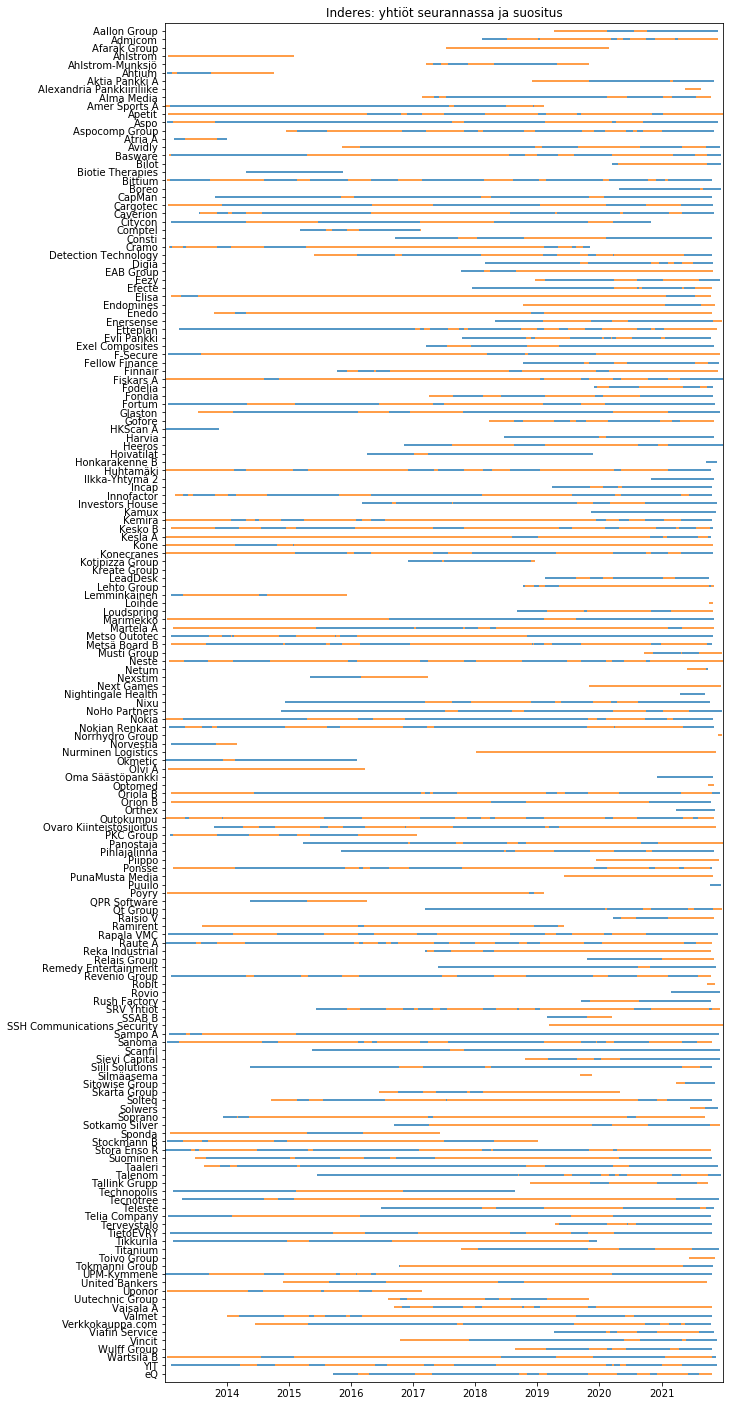

In [500]:
# Visualize Inderes follow-up and recommendation during it
temp = intervals[~intervals['PvmSuositusEdellinen'].isnull()]
stocks = temp['Osake'].unique()
y_axis = pd.Series(np.arange(len(stocks),0,-1), index=stocks)
y, x1, x2 = temp['Osake'].map(y_axis), temp['PvmSuositusEdellinen'], temp['PvmSuositus']
cx = np.where(temp['Salkussa'], 'tab:blue', 'tab:orange')
fig, ax = plt.subplots(1,1, figsize=(10,25))
ax.hlines(y=y, xmin=x1, xmax=x2, color=cx)
ax.set_yticks(y_axis)
ax.set_yticklabels(y_axis.index)
ax.set_xlim(x1.min(), x2.max())
ax.set_ylim(0, len(y_axis) + 1)
ax.set_title('Inderes: yhtiöt seurannassa ja suositus')
plt.show()

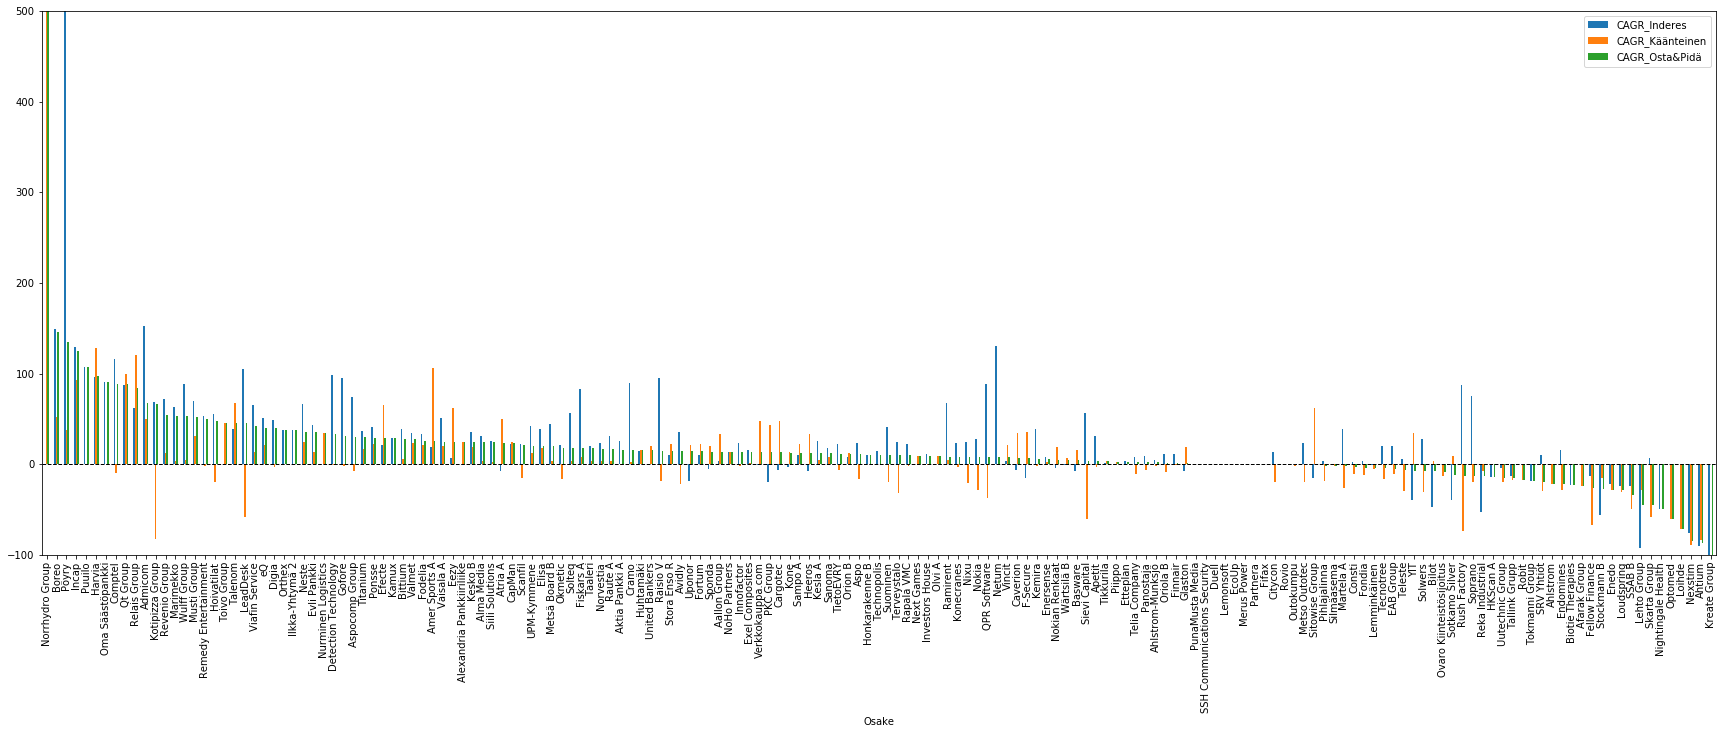

In [501]:
fig, ax = plt.subplots(1,1, figsize=(30,10))
comparison = statistics.set_index('Osake')[['CAGR_Inderes', 'CAGR_Käänteinen', 'CAGR_Osta&Pidä']].copy()
comparison.sort_values('CAGR_Osta&Pidä', ascending=False, inplace=True)
comparison = np.round((comparison-1)*100)
comparison.plot(ax=ax, kind='bar')
ax.set_ylim(-100,500)
ax.axhline(0, linestyle='dashed', color='black', linewidth=1)

### Permutation test

In [502]:
cagrs = []
for b in range(200):
    #print(b, end=',')
    intervals['Apina'] = np.random.permutation(intervals['Suositus'])
    apina = intervals.groupby('Osake', as_index=False).apply(lambda df: get_statistics(df, strategy='Apina',
                               price='Päätöskurssi + Osinko (Seuraava)', day='PvmKaupankäynti (Seuraava)'))
    exposure = (apina['Pitoaika'] / buyhold['Pitoaika'].max()).fillna(0)
    cagr = geom_mean(apina['CAGR'], exposure) #apina['CAGR'].mean()
    cagrs.append(cagr)
cagrs = np.array(cagrs)

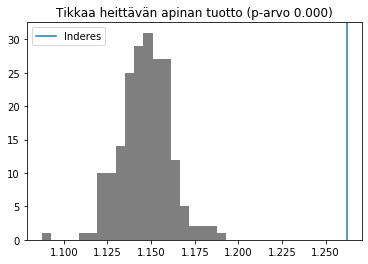

In [503]:
p_arvo = (cagrs >= inderes_mc).mean()
plt.hist(cagrs, bins=20, color='tab:grey') #np.arange(1,2,0.05)
plt.axvline(inderes_mc, label='Inderes', color='tab:blue')
#plt.axvline(reverse_mc, label='Käänteinen', color='tab:orange')
#plt.axvline(indeksi_mc, label='Osta&Pidä', color='tab:green')
plt.title('Tikkaa heittävän apinan tuotto (p-arvo %.3f)' % p_arvo)
plt.legend()


In [504]:
print(np.mean(cagrs), np.std(cagrs))
print('Sigmas Inderes: % .2f' % ((inderes_mc - np.mean(cagrs)) / np.std(cagrs)))

1.1468980372661017 0.01411602385652824
Sigmas Inderes:  8.15


### Based on trading volume

In [505]:
import os
# Source: https://www.kauppalehti.fi/porssi/kurssit/XHEL/historia/2021-12-31
#         https://www.kauppalehti.fi/porssi/kurssit/FNFI/historia/2021-12-31
market = pd.read_csv(os.path.join('päätöskurssit', 'XHEL_päätöskurssit_2021-12-31.csv'), sep=';', decimal=',')
stocks_all = list(market.sort_values('Vaihto €', ascending=False)['Osake'])
stocks_25, stocks_large, stocks_medium, stocks_small = stocks_all[:25], stocks_all[0:40], stocks_all[40:80], stocks_all[80:]
capitalization = ["fn", "smallcap", "midcap", "largecap"]

In [506]:
market = pd.read_csv(os.path.join('päätöskurssit', 'FNFI_päätöskurssit_2021-12-31.csv'), sep=';', decimal=',')
stocks_fn = list(market.sort_values('Vaihto €', ascending=False)['Osake'])

In [508]:
stock_category = pd.DataFrame(#[(stock, "omxh25*") for stock in stocks_25] + 
                              [(stock, "largecap") for stock in stocks_large] + 
                              [(stock, "midcap") for stock in stocks_medium] +
                              [(stock, "smallcap") for stock in stocks_small] +
                              [(stock, "fn") for stock in stocks_fn],
                              columns=["Osake", "Kategoria"])
statistics = statistics.merge(stock_category, on="Osake")

In [509]:
category_performance = dict()
for category, statistics_category in statistics.groupby('Kategoria'):
    print(category)
    # Osta/Lisää tuotto
    exposure = (statistics_category['Pitoaika_Inderes'] / statistics_category['Pitoaika_Osta&Pidä'].max()).fillna(0)
    mc1 = geom_mean(statistics_category['CAGR_Inderes'], exposure) if exposure.sum() > 0 else 1.0
    # Myy/Vähennä tuotto
    exposure = (statistics_category['Pitoaika_Käänteinen'] / statistics_category['Pitoaika_Osta&Pidä'].max()).fillna(0)
    mc2 = geom_mean(statistics_category['CAGR_Käänteinen'], exposure) if exposure.sum() > 0 else 1.0
    # Osta & Pidä tuotto
    exposure = (statistics_category['Pitoaika_Osta&Pidä'] / statistics_category['Pitoaika_Osta&Pidä'].max()).fillna(0)
    mc3 = geom_mean(statistics_category['CAGR_Osta&Pidä'], exposure) if exposure.sum() > 0 else 1.0
    category_performance[category] = pd.Series({'Inderes': mc1, 'Käänteinen': mc2, 'Osta&Pidä': mc3})
category_performance = pd.DataFrame(category_performance).transpose()
category_performance = category_performance.loc[capitalization,]

fn
largecap
midcap
smallcap


In [510]:
category_performance.round(3)

,Inderes,Käänteinen,Osta&Pidä
fn,1.321,0.999,1.138
smallcap,1.253,0.981,1.109
midcap,1.270,1.013,1.149
largecap,1.212,1.088,1.133


Text(0, 0.5, 'Tuotto (%, kategorian osakkeet)')

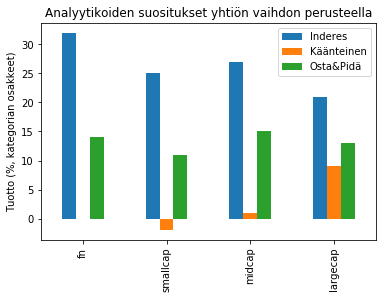

In [511]:
fig, ax = plt.subplots(1,1)
np.round((category_performance-1)*100).plot(ax=ax, kind='bar')
ax.set_title("Analyytikoiden suositukset yhtiön vaihdon perusteella")
ax.set_ylabel("Tuotto (%, kategorian osakkeet)")

## Portfolio changes

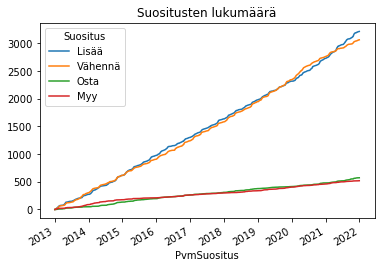

In [512]:
recs = recommendations.groupby('PvmSuositus')['Suositus'].value_counts().unstack(level=1).fillna(0).cumsum()
recs[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(title = 'Suositusten lukumäärä')

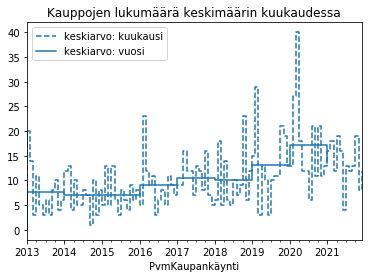

In [513]:
# For each trading day, was a stock bought or sold?
is_trade = lambda s : (s.isin(['Osta','Lisää']) & s.shift(1).isin(['Myy', 'Vähennä'])) |\
                      (s.isin(['Myy', 'Vähennä']) & s.shift(1).isin(['Osta','Lisää'])) |\
                      (s.isin(['Osta','Lisää']) & s.shift(1).isnull())
trades = pd.Series(returns.groupby(['Osake'])['Suositus'].apply(is_trade).values, index=returns['PvmKaupankäynti'])

# Plot in monthly/yearly smoothed average per month
events_month = trades.groupby(pd.Grouper(freq="M")).sum()
events_smooth = trades.groupby(pd.Grouper(freq="Y")).sum()/12
ax = events_month.plot(drawstyle='steps-post', linestyle='dashed', color='tab:blue', label='keskiarvo: kuukausi')
events_smooth.plot(ax=ax, drawstyle='steps-post', linestyle='solid', color='tab:blue', label='keskiarvo: vuosi')
ax.set_title('Kauppojen lukumäärä keskimäärin kuukaudessa')
ax.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2021-12-31'))
ax.legend()

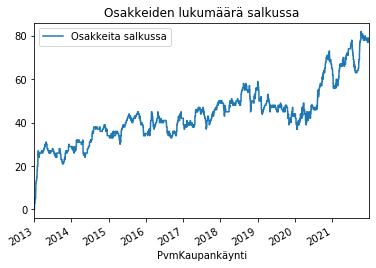

In [514]:
def portfolio_change(s):
    add = (s.isin(['Osta','Lisää']) & (s.shift(1).isin(['Myy', 'Vähennä']) | s.shift(1).isnull()))
    reduce = (s.isin(['Myy', 'Vähennä', '-']) & s.shift(1).isin(['Osta','Lisää']))
    change = pd.Series(np.where(add, 1, np.where(reduce, -1, 0)), index=s.index)
    return(change)
stocks = pd.Series(returns.groupby('Osake')['Suositus'].apply(portfolio_change).values, index=returns['PvmKaupankäynti'])
stocks = stocks.groupby(level=0).sum().cumsum()

ax = stocks.plot(drawstyle='steps-post', linestyle='solid', color='tab:blue', label='Osakkeita salkussa')
ax.set_title('Osakkeiden lukumäärä salkussa')
ax.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2021-12-31'))
ax.legend()

# Recommendation total return index

In [522]:
def index_return(growth):
    growth = growth.dropna()
    d = (growth.index[-1] - growth.index[0]).days
    r = growth.iloc[-1,] ** (365.25/d)
    return(r)

### Trading intervals from every trading day to the next

In [765]:
# This is the recommendation mapped to next true trading day in data
intervals = returns.groupby(['Osake', 'PvmSuositus'], as_index=False).first()
intervals = intervals[['Osake', 'PvmKaupankäynti', 'PvmSuositus', 'Suositus', 'Tavoite']]

In [766]:
# Some trading days are missing for a given stock. Maybe the trading was halted, there was no trade, or the data has problem
trading_days = pd.Index(pd.to_datetime(np.sort(prices['PvmKaupankäynti'].unique())), name = 'PvmKaupankäynti')

# Fill these as 'the stock did not change from previous day', this makes it easy to calculate portfolio return (unbiased)
def fill_price_between(df_stock):
    df_stock = df_stock.set_index('PvmKaupankäynti').drop(columns='Osake')
    trading_first, trading_last = df_stock.index[0], df_stock.index[-1]
    df_stock = df_stock.reindex(trading_days)[trading_first:trading_last]#.fillna(method='ffill')
    return(df_stock)

prices_filled = prices.groupby('Osake').apply(fill_price_between).reset_index()

In [767]:
returns_filled = prices_filled.merge(intervals, on=['Osake', 'PvmKaupankäynti'], how='left', sort=True)
# Fill the recommendation forward to all subsequent trading days
fill_cols = ['PvmSuositus', 'Suositus', 'Tavoite']
returns_filled[fill_cols] = returns_filled.groupby('Osake')[fill_cols].fillna(method='ffill')
# Add profit in each trading day
returns_filled['Tuotto (%)'] = returns_filled.groupby('Osake')['Päätöskurssi + Osinko'].apply(lambda s: s/s.shift(1) - 1)

In [768]:
# Add Salkussa (Inderes), Salkussa (Käänteinen), Salkussa (Osta&Pidä), Salkussa (Indeksi)
returns_filled['Salkussa (Inderes)'] = returns_filled.groupby('Osake')['Suositus'].apply(lambda s: s.shift(1).isin(['Osta', 'Lisää']))
returns_filled['Salkussa (Käänteinen)'] = returns_filled.groupby('Osake')['Suositus'].apply(lambda s: s.shift(1).isin(['Myy', 'Vähennä']))
returns_filled['Salkussa (Osta&Pidä)'] = returns_filled.groupby('Osake')['Suositus'].apply(lambda s: ~s.shift(1).isnull())
returns_filled['Salkussa (Indeksi)']= returns_filled.groupby('Osake')['PvmKaupankäynti'].apply(lambda s: ~s.shift(1).isnull())
returns_filled['Salkussa (Inderes+1)'] = returns_filled.groupby('Osake')['Suositus'].apply(lambda s: s.shift(2).isin(['Osta', 'Lisää']))


In [769]:
returns_filled = returns_filled.merge(stock_category, on="Osake")

### Number of stocks for different strategies

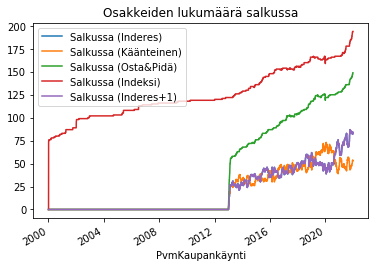

In [679]:
portfolios = ['Salkussa (Inderes)', 'Salkussa (Käänteinen)','Salkussa (Osta&Pidä)','Salkussa (Indeksi)', 'Salkussa (Inderes+1)']
n_stocks = returns_filled.groupby('PvmKaupankäynti')[portfolios].sum()
n_stocks.plot(title='Osakkeiden lukumäärä salkussa')


In [520]:
inderes_start = n_stocks[n_stocks['Salkussa (Inderes)'] > 0].index[0]
inderes_start 

Timestamp('2013-01-04 00:00:00')

### Total returns for different strategies

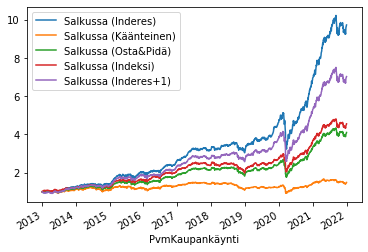

In [521]:
growth = {}
for portfolio in portfolios:
    in_portfolio = returns_filled[portfolio] & (returns_filled['PvmKaupankäynti'] >= pd.Timestamp('2013-01-03'))
    pct_day = returns_filled[in_portfolio].groupby('PvmKaupankäynti')['Tuotto (%)'].mean()
    pct_cum = (1.0 + pct_day).cumprod()
    growth[portfolio] = pct_cum
growth = pd.DataFrame(growth).fillna(1.0) # first day stocks purchased
growth.plot()

In [523]:
index_return(growth)

Salkussa (Inderes)       1.287942
Salkussa (Käänteinen)    1.045120
Salkussa (Osta&Pidä)     1.169977
Salkussa (Indeksi)       1.183694
Salkussa (Inderes+1)     1.242184
Name: 2021-12-30 00:00:00, dtype: float64

### Total returns for different strategies over the years

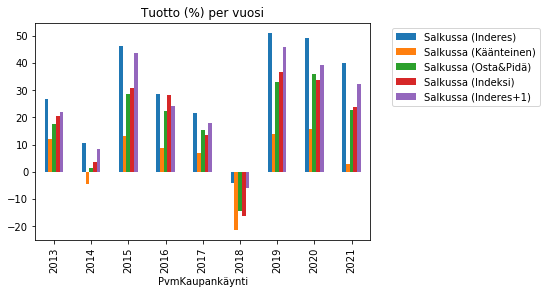

In [524]:
# Count return per year from this index
growth_year = (growth / growth.shift(1)).groupby(growth.index.year).prod()
growth_year = (growth_year - 1) * 100 
growth_year.plot.bar(title='Tuotto (%) per vuosi')
plt.legend(bbox_to_anchor=(1.05, 1.0))

### Total returns for different strategies based on trading volume

In [525]:
# Calculate index by different market cap / traded volume
growth_category = {}
for portfolio in ['Salkussa (Inderes)', 'Salkussa (Osta&Pidä)']:
    pct_day = returns_filled[returns_filled[portfolio]].groupby(['Kategoria','PvmKaupankäynti'])['Tuotto (%)'].mean()
    pct_cum = (1.0 + pct_day.unstack(level=0)).cumprod()
    growth_category[portfolio] = pct_cum

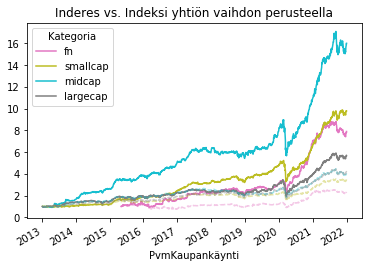

In [533]:
fig, ax = plt.subplots(1,1)
colors = ['tab:pink', 'tab:olive', 'tab:cyan', 'tab:grey']
growth_category['Salkussa (Inderes)'][capitalization].plot(ax=ax, linestyle='solid', color=colors, 
                                                           title='Inderes vs. Indeksi yhtiön vaihdon perusteella')
growth_category['Salkussa (Osta&Pidä)'][capitalization].plot(ax=ax, linestyle='dashed', color=colors, legend=False, alpha=0.4)

In [534]:
r = pd.concat([growth_category['Salkussa (Inderes)'].apply(index_return)[capitalization],
               growth_category['Salkussa (Osta&Pidä)'].apply(index_return)[capitalization]], axis=1)
r.columns = ['Inderes', 'Osta&Pidä']
r

,Inderes,Osta&Pidä
Kategoria,,
fn,1.363850,1.136359
smallcap,1.289149,1.148906
midcap,1.362094,1.168496
largecap,1.213033,1.172410


# 'Inderes effect': Instant return following a recommendation

In [771]:
# Add index return to each stock and trading day
indeksi = returns_filled[returns_filled['Salkussa (Indeksi)']].groupby('PvmKaupankäynti')['Tuotto (%)'].mean()
returns_filled['Indeksi (%)'] = returns_filled['PvmKaupankäynti'].map(indeksi)
# Add n'th day from recommendation to each stock and trading day
index_like = lambda s: pd.Series(np.arange(len(s)), index=s.index)
returns_filled['Pvm.i'] = returns_filled.groupby(['Osake', 'PvmSuositus'])['Suositus'].apply(index_like)
# Add year
returns_filled['Vuosi'] = returns_filled['PvmKaupankäynti'].dt.year

In [772]:
# Add info about recommendation change
intervals = returns_filled.groupby(['Osake', 'PvmSuositus'], as_index=False).first()
intervals['SuositusEdellinen'] = intervals.groupby('Osake')['Suositus'].shift(1)
intervals['SuositusMuutos'] = intervals['SuositusEdellinen'].astype('str') + "->" + intervals['Suositus'].astype('str')
returns_filled = returns_filled.merge(intervals[['Osake', 'PvmSuositus', 'SuositusMuutos']], 
                                      on=['Osake', 'PvmSuositus'], how='left')

#### Return on i'th trading day from recommendation

In [773]:
# Calculate mean profit on i'th trading day from recommendaton
profit_i = returns_filled.groupby(['Suositus', 'Pvm.i'], as_index=False)[['Tuotto (%)', 'Indeksi (%)']].mean()
inderes = profit_i.pivot(index='Pvm.i', columns='Suositus', values='Tuotto (%)')
indeksi = profit_i.pivot(index='Pvm.i', columns='Suositus', values='Indeksi (%)')

(-0.05, 0.15)

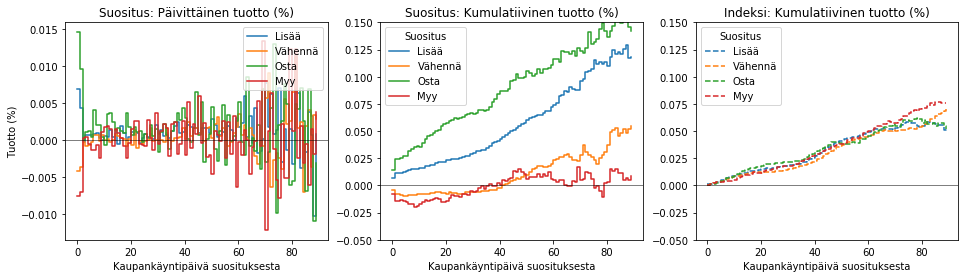

In [628]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4), sharex=True)
inderes.iloc[0:90,][['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax1, drawstyle='steps-post')
((1.0 + inderes).cumprod()-1).iloc[0:90,][['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax2, drawstyle='steps-post')
((1.0 + indeksi).cumprod()-1).iloc[0:90,][['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax3, drawstyle='steps-post', linestyle='dashed')
ax1.set_ylabel('Tuotto (%)')
ax1.set_xlabel('Kaupankäyntipäivä suosituksesta')
ax2.set_xlabel('Kaupankäyntipäivä suosituksesta')
ax3.set_xlabel('Kaupankäyntipäivä suosituksesta')
ax1.set_title('Suositus: Päivittäinen tuotto (%)')
ax2.set_title('Suositus: Kumulatiivinen tuotto (%)')
ax3.set_title('Indeksi: Kumulatiivinen tuotto (%)')
ax1.axhline(0.0,color='black',linewidth=0.5)
ax2.axhline(0.0,color='black',linewidth=0.5)
ax3.axhline(0.0,color='black',linewidth=0.5)
ax1.legend(loc=1)
ax2.set_ylim([-0.05,0.15])
ax3.set_ylim([-0.05,0.15])

#### Return on i'th trading day based on trading volume

In [774]:
# Calculate mean profit on i'th trading day from recommendaton for different market caps
profit_i = returns_filled.groupby(['Kategoria', 'Suositus', 'Pvm.i'], as_index=False)[['Tuotto (%)', 'Indeksi (%)']].mean()
inderes = profit_i.pivot(index='Pvm.i', columns=['Kategoria', 'Suositus'], values='Tuotto (%)')
indeksi = profit_i.pivot(index='Pvm.i', columns=['Kategoria', 'Suositus'], values='Indeksi (%)')

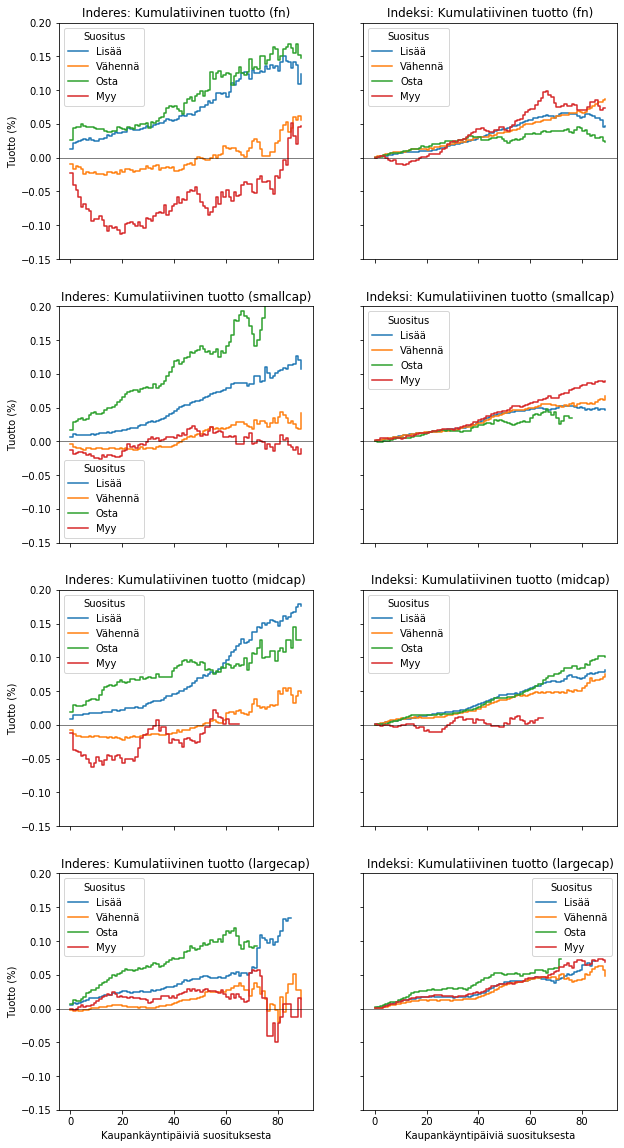

In [630]:
fig, axs = plt.subplots(4,2, figsize=(10,20), sharex=True)
for cap, ax12 in zip(capitalization, axs):
    ax1, ax2 = ax12[0], ax12[1]
    ax1.get_shared_y_axes().join(ax1, ax2)
    ((1.0 + inderes[cap]).cumprod() - 1).iloc[0:90,][['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax1, drawstyle='steps-post')
    ((1.0 + indeksi[cap]).cumprod() - 1).iloc[0:90,][['Lisää', 'Vähennä', 'Osta', 'Myy']].plot(ax=ax2, drawstyle='steps-post')
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_ylabel('Tuotto (%)')
    ax1.set_xlabel('Kaupankäyntipäiviä suosituksesta')
    ax2.set_xlabel('Kaupankäyntipäiviä suosituksesta')
    ax1.set_title('Inderes: Kumulatiivinen tuotto (%s)' % cap)
    ax2.set_title('Indeksi: Kumulatiivinen tuotto (%s)' % cap)
    ax1.axhline(0.0,color='black',linewidth=0.5)
    ax2.axhline(0.0,color='black',linewidth=0.5)
    ax1.set_ylim([-0.15, 0.2])


#### Total Inderes effect over first 3 trading days

In [631]:
agg = lambda s: (1.0+s).prod()-1
order = ['Osta', 'Lisää', 'Vähennä', 'Myy']

In [632]:
# Inderes effect in days 1, 2, 3 together
inderes = profit_i[profit_i['Pvm.i'].isin([0,1,2])].groupby(['Kategoria', 'Suositus'])['Tuotto (%)'].apply(agg)
inderes = inderes.reset_index().pivot(index='Kategoria', columns='Suositus', values='Tuotto (%)').loc[capitalization, order].round(3)
inderes

Suositus,Osta,Lisää,Vähennä,Myy
Kategoria,,,,
fn,0.046,0.023,-0.012,-0.047
smallcap,0.030,0.010,-0.010,-0.017
midcap,0.028,0.015,-0.016,-0.039
largecap,0.012,0.007,-0.003,-0.001


In [775]:
# Sanity check: index returns from the recommendation day onwards should not have signal
indeksi = profit_i[profit_i['Pvm.i'].isin([0,1,2])].groupby(['Kategoria', 'Suositus'])['Indeksi (%)'].apply(agg)
indeksi = indeksi.reset_index().pivot(index='Kategoria', columns='Suositus', values='Indeksi (%)').loc[capitalization, order].round(3)
indeksi

Suositus,Osta,Lisää,Vähennä,Myy
Kategoria,,,,
fn,0.001,0.002,0.003,0.002
smallcap,-0.001,0.001,0.002,0.005
midcap,0.001,0.002,0.002,-0.001
largecap,0.003,0.003,0.001,0.001


#### Total Inderes effect over first 3 trading days: previous recommendation

In [653]:
# The change in recommendation is also important..
profit_i = returns_filled.groupby(['Kategoria', 'SuositusMuutos', 'Pvm.i'], as_index=False)['Tuotto (%)'].mean()
inderes = profit_i[profit_i['Pvm.i'].isin([0,1,2])].groupby(['Kategoria', 'SuositusMuutos'])['Tuotto (%)'].apply(agg)
inderes = inderes.reset_index().pivot(index='Kategoria', columns='SuositusMuutos', values='Tuotto (%)')
inderes.loc[capitalization, ['Vähennä->Osta', 'Lisää->Osta', 'Vähennä->Lisää', 'Lisää->Lisää', 
                             'Vähennä->Vähennä', 'Lisää->Vähennä', 'Vähennä->Myy', 'Lisää->Myy']].round(3)

SuositusMuutos,Vähennä->Osta,Lisää->Osta,Vähennä->Lisää,Lisää->Lisää,Vähennä->Vähennä,Lisää->Vähennä,Vähennä->Myy,Lisää->Myy
Kategoria,,,,,,,,
fn,0.037,0.075,0.036,0.023,-0.006,-0.042,-0.074,-0.114
smallcap,0.064,0.054,0.025,0.008,-0.007,-0.026,-0.032,-0.059
midcap,0.089,0.040,0.035,0.012,-0.006,-0.050,-0.080,0.062
largecap,NaN,0.027,0.024,0.004,-0.000,-0.023,-0.016,-0.012


#### Total Inderes effect over first 3 trading days: over different years

In [650]:
# Calculate mean profit on i'th trading day from recommendaton for different market cap and year
profit_i = returns_filled.groupby(['Vuosi', 'Kategoria', 'Suositus', 'Pvm.i'], as_index=False)['Tuotto (%)'].mean()
profit_i = profit_i[profit_i['Pvm.i'] <= 2].groupby(['Vuosi', 'Kategoria', 'Suositus'])['Tuotto (%)'].apply(agg).reset_index()

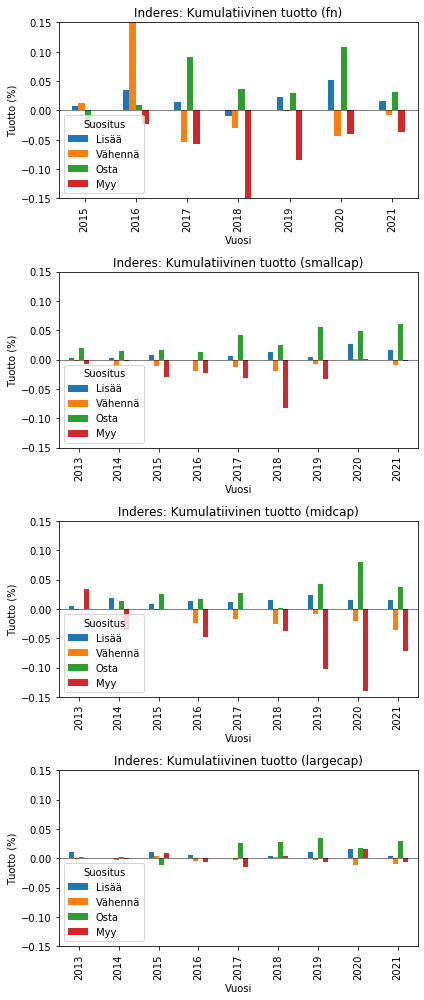

In [651]:
fig, axs = plt.subplots(4,1, figsize=(6,14), sharey=True)
for cap, ax in zip(capitalization, axs):
    temp = profit_i[profit_i['Kategoria'] == cap].pivot(index='Vuosi', columns='Suositus', values='Tuotto (%)')
    #temp.index = temp.index.astype(int)
    temp[['Lisää', 'Vähennä', 'Osta', 'Myy']].plot.bar(ax=ax)
    #ax.set_ylim([0.8,1.2])
    ax.set_ylabel('Tuotto (%)')
    ax.set_xlabel('Vuosi')
    ax.set_title('Inderes: Kumulatiivinen tuotto (%s)' % cap)
    ax.axhline(0.0,color='black',linewidth=0.5)
    ax.set_ylim(-0.15,0.15)
fig.tight_layout()

# Returns 365d from recommendation

In [776]:
intervals = returns_filled.groupby(['Osake', 'PvmSuositus'], as_index=False).first()

In [777]:
# Trading days may not neatly match 30d, 60d, 90d, ... so fill between 
def fill_price_between(df_stock):
    df_stock = df_stock.set_index('PvmKaupankäynti')
    trading_days = df_stock.index
    first, last = trading_days[0], trading_days[-1]
    df_stock = df_stock.reindex(pd.date_range(first, last)).fillna(method='ffill')
    df_stock['Tuotto_30d'] = df_stock['Päätöskurssi + Osinko'].shift(-30)/df_stock['Päätöskurssi + Osinko'] - 1
    df_stock['Tuotto_60d'] = df_stock['Päätöskurssi + Osinko'].shift(-60)/df_stock['Päätöskurssi + Osinko'] - 1
    df_stock['Tuotto_90d'] = df_stock['Päätöskurssi + Osinko'].shift(-90)/df_stock['Päätöskurssi + Osinko'] - 1
    df_stock['Tuotto_120d'] = df_stock['Päätöskurssi + Osinko'].shift(-120)/df_stock['Päätöskurssi + Osinko'] - 1
    df_stock['Tuotto_365d'] = df_stock['Päätöskurssi + Osinko'].shift(-365)/df_stock['Päätöskurssi + Osinko'] - 1
    df_stock = df_stock.reindex(trading_days)
    return(df_stock[['Tuotto_30d', 'Tuotto_60d', 'Tuotto_90d', 'Tuotto_120d', 'Tuotto_365d']])

returns_Xd = prices.groupby('Osake').apply(fill_price_between).reset_index()
#returns_Xd.head()

In [778]:
intervals = intervals.merge(returns_Xd, on=['Osake', 'PvmKaupankäynti'], how='left')

In [779]:
# Index trading days may not neatly match 30d, 60d, 90d, ... so fill between 
indeksi = returns_filled[returns_filled['Salkussa (Indeksi)']].groupby('PvmKaupankäynti')['Tuotto (%)'].mean()
first, last = indeksi.index[0], indeksi.index[-1]
all_days = pd.Index(pd.date_range(first, last), name='PvmKaupankäynti')
indeksi_Xd = pd.DataFrame({'Indeksi': (1+indeksi).cumprod()}, index = all_days)
indeksi_Xd = indeksi_Xd.fillna(method='ffill').fillna(1.0)
for d in [30,60,90,120,365]:
    indeksi_Xd['Indeksi_%dd' % d] = indeksi_Xd['Indeksi'].shift(-d) / indeksi_Xd['Indeksi'] - 1
indeksi_Xd = indeksi_Xd.reset_index()
#indeksi_Xd.head()

In [695]:
intervals = intervals.merge(indeksi_Xd, on=['PvmKaupankäynti'], how='left')

In [715]:
def bootstrap_mean(x):
    x = x[~np.isnan(x)]
    bootstrap_means = [np.random.choice(x, len(x)).mean() for i in range(10000)] 
    mean = np.mean(x)
    median = np.median(x)
    lci = np.quantile(x, 0.025)
    uci = np.quantile(x, 0.975)
    mean_lci = np.quantile(bootstrap_means, 0.025)
    mean_uci = np.quantile(bootstrap_means, 0.975)
    return(pd.Series({'mean': mean, 'median': median, '95% lower': lci, '95% upper':uci, 
                      'mean 95% lower': mean_lci, 'mean 95% upper': mean_uci}))

In [ ]:
import seaborn as sns

#### Inderes: 365d from recommendation

Text(0, 0.5, 'Suositusten lukumäärä')

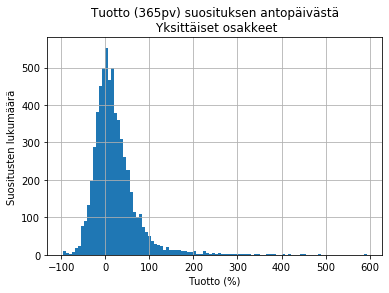

In [697]:
fig, ax = plt.subplots(1,1)
(intervals['Tuotto_365d']*100).hist(bins=100)
ax.set_title('Tuotto (365pv) suosituksen antopäivästä\n Yksittäiset osakkeet')
ax.set_xlabel('Tuotto (%)')
ax.set_ylabel('Suositusten lukumäärä')

In [724]:
# 1 year returns and their confidence interval from the recommendation day
stat = intervals.groupby('Suositus')['Tuotto_365d'].apply(bootstrap_mean).unstack(level=1).loc[order,]
stat.round(3)

,mean,median,95% lower,95% upper,mean 95% lower,mean 95% upper
Suositus,,,,,,
Osta,0.271,0.200,-0.531,1.653,0.225,0.320
Lisää,0.274,0.167,-0.422,1.675,0.253,0.295
Vähennä,0.150,0.079,-0.488,1.206,0.133,0.167
Myy,0.075,0.034,-0.540,0.916,0.037,0.114


(-1, 4)

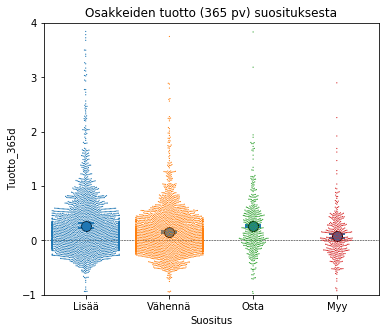

In [735]:
stat['mean 95% -'] = stat['mean'] - stat['mean 95% lower']
stat['mean 95% +'] = stat['mean 95% upper'] - stat['mean']

fig, ax = plt.subplots(1,1, figsize=(6,5))
orderx = ['Lisää', 'Vähennä', 'Osta', 'Myy']
sns.swarmplot(ax=ax, data=intervals, x="Suositus", y="Tuotto_365d", order=orderx, size=1.2)
stat.loc[orderx,'mean'].plot(marker='o', linestyle='', ax=ax, yerr=stat[['mean 95% -', 'mean 95% +']].T.values,
                  capsize=8, capthick=2, markeredgecolor='black', markersize=10)
ax.set_title('Osakkeiden tuotto (365 pv) suosituksesta')
ax.axhline(0.0, color='black', linestyle='dashed', linewidth=0.5)
ax.set_ylim(-1, 4)

#### Inderes vs. Index: 365d from recommendation

In [739]:
intervals['Tuottoero_365d'] = (intervals['Tuotto_365d'] - intervals['Indeksi_365d'])

Text(0, 0.5, 'Suositusten lukumäärä')

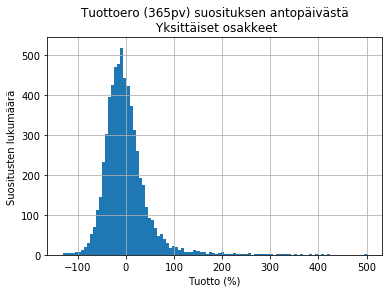

In [740]:
fig, ax = plt.subplots(1,1)
(intervals['Tuottoero_365d']*100).hist(bins=100)
ax.set_title('Tuottoero (365pv) suosituksen antopäivästä\n Yksittäiset osakkeet')
ax.set_xlabel('Tuotto (%)')
ax.set_ylabel('Suositusten lukumäärä')

In [741]:
# 1 year returns and their confidence interval from the recommendation day
stat = intervals.groupby('Suositus')['Tuottoero_365d'].apply(bootstrap_mean).unstack(level=1).loc[order,]
stat.round(3)

,mean,median,95% lower,95% upper,mean 95% lower,mean 95% upper
Suositus,,,,,,
Osta,0.049,-0.020,-0.637,1.107,0.008,0.091
Lisää,0.058,-0.019,-0.623,1.282,0.039,0.078
Vähennä,-0.064,-0.111,-0.675,0.871,-0.079,-0.049
Myy,-0.136,-0.173,-0.886,0.800,-0.175,-0.096


(-1, 4)

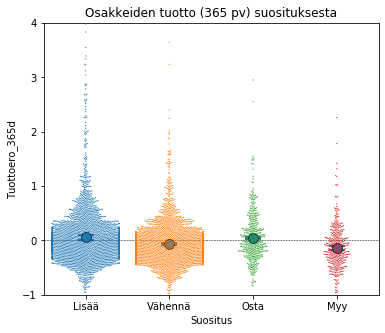

In [742]:
stat['mean 95% -'] = stat['mean'] - stat['mean 95% lower']
stat['mean 95% +'] = stat['mean 95% upper'] - stat['mean']

fig, ax = plt.subplots(1,1, figsize=(6,5))
orderx = ['Lisää', 'Vähennä', 'Osta', 'Myy']
sns.swarmplot(ax=ax, data=intervals, x="Suositus", y="Tuottoero_365d", order=orderx, size=1.2)
stat.loc[orderx,'mean'].plot(marker='o', linestyle='', ax=ax, yerr=stat[['mean 95% -', 'mean 95% +']].T.values,
                  capsize=8, capthick=2, markeredgecolor='black', markersize=10)
ax.set_title('Osakkeiden tuotto (365 pv) suosituksesta')
ax.axhline(0.0, color='black', linestyle='dashed', linewidth=0.5)
ax.set_ylim(-1, 4)